## Import packages

In [2]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Set pd to show all columns
pd.set_option('display.max_columns', None)

## Data Setup

#### Define columns

In [3]:
data = pd.read_csv('HR_data.csv', index_col=0)
#Remove rows with missing values
data = data.dropna()


biometrics = ['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew',
       'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std',
       'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max',
       'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT']

emotions = ['Frustrated', 'upset', 'hostile', 'alert',
       'ashamed', 'inspired', 'nervous', 'attentive', 'afraid', 'active',
       'determined']


phase1_data = data[data['Phase'] == "phase1"]
phase2_data = data[data['Phase'] == "phase2"]


# merge dataframes 
phase_data = pd.merge(phase1_data, phase2_data, on=["Individual","Round","Cohort"], suffixes=('_1', '_2'))


#### Calculate delta 

In [4]:
# create a delta column for each biometric
for biometric in biometrics:
    phase_data[biometric + "_delta"] = phase_data[biometric + "_2"] - phase_data[biometric + "_1"]

# create a delta column for each emotion
for emotion in emotions:
    phase_data[emotion + "_delta"] = phase_data[emotion + "_2"] - phase_data[emotion + "_1"]

delta_columns = [biometric + "_delta" for biometric in biometrics] + [emotion + "_delta" for emotion in emotions]


# only keep delta columns and "puzzler"
prepared_data = phase_data[delta_columns + ["Puzzler_1"]]

# rename "puzzler_1" to "puzzler"
prepared_data = prepared_data.rename(columns={"Puzzler_1": "Puzzler"})

#### Setup data, X and Y - puzzler / non-puzzler

In [5]:
data = pd.read_csv('HR_data.csv', index_col=0)
#Remove rows with missing values
data = data.dropna()

puzzler = prepared_data[prepared_data['Puzzler'] == 1]
non_puzzler = prepared_data[prepared_data['Puzzler'] == 0]

biometrics = ['HR_TD_Mean_delta', 'HR_TD_Median_delta', 'HR_TD_std_delta', 'HR_TD_Min_delta', 'HR_TD_Max_delta',
       'HR_TD_AUC_delta', 'HR_TD_Kurtosis_delta', 'HR_TD_Skew_delta', 'HR_TD_Slope_min_delta',
       'HR_TD_Slope_max_delta', 'HR_TD_Slope_mean_delta', 'HR_TD_Slope_delta', 'TEMP_TD_Mean_delta',
       'TEMP_TD_Median_delta', 'TEMP_TD_std_delta', 'TEMP_TD_Min_delta', 'TEMP_TD_Max_delta',
       'TEMP_TD_AUC_delta', 'TEMP_TD_Kurtosis_delta', 'TEMP_TD_Skew_delta', 'TEMP_TD_Slope_min_delta',
       'TEMP_TD_Slope_max_delta', 'TEMP_TD_Slope_mean_delta', 'TEMP_TD_Slope_delta',
       'EDA_TD_P_Mean_delta', 'EDA_TD_P_Median_delta', 'EDA_TD_P_std_delta', 'EDA_TD_P_Min_delta',
       'EDA_TD_P_Max_delta', 'EDA_TD_P_AUC_delta', 'EDA_TD_P_Kurtosis_delta', 'EDA_TD_P_Skew_delta',
       'EDA_TD_P_Slope_min_delta', 'EDA_TD_P_Slope_max_delta', 'EDA_TD_P_Slope_mean_delta',
       'EDA_TD_P_Slope_delta', 'EDA_TD_T_Mean_delta', 'EDA_TD_T_Median_delta', 'EDA_TD_T_std_delta',
       'EDA_TD_T_Min_delta', 'EDA_TD_T_Max_delta', 'EDA_TD_T_AUC_delta', 'EDA_TD_T_Kurtosis_delta',
       'EDA_TD_T_Skew_delta', 'EDA_TD_T_Slope_min_delta', 'EDA_TD_T_Slope_max_delta',
       'EDA_TD_T_Slope_mean_delta', 'EDA_TD_T_Slope_delta', 'EDA_TD_P_Peaks_delta',
       'EDA_TD_P_RT_delta', 'EDA_TD_P_ReT_delta']

emotions = ['Frustrated_delta', 'upset_delta', 'hostile_delta', 'alert_delta',
       'ashamed_delta', 'inspired_delta', 'nervous_delta', 'attentive_delta', 'afraid_delta', 'active_delta',
       'determined_delta']
neg_emotions = ['Frustrated_delta', 'upset_delta', 'hostile_delta', 'ashamed_delta', 'nervous_delta', 'afraid_delta']
pos_emotions = ['alert_delta', 'inspired_delta', 'attentive_delta', 'active_delta', 'determined_delta']
categories = ['Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']

X_puzzler = puzzler[biometrics]
#y_puzzler sum of positive emotions and sum of negative emotions
y_puzzler = puzzler[emotions]
y_puzzler['Neg_emotions'] = y_puzzler[neg_emotions].sum(axis=1)
y_puzzler['Pos_emotions'] = y_puzzler[pos_emotions].sum(axis=1)


X_non_puzzler = non_puzzler[biometrics]
y_non_puzzler = non_puzzler[emotions]
y_non_puzzler['Neg_emotions'] = y_non_puzzler[neg_emotions].sum(axis=1)
y_non_puzzler['Pos_emotions'] = y_non_puzzler[pos_emotions].sum(axis=1)


/var/folders/_n/368hq85j0kj9gqq2gh6v174c0000gn/T/ipykernel_37230/1947697637.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_puzzler['Neg_emotions'] = y_puzzler[neg_emotions].sum(axis=1)
/var/folders/_n/368hq85j0kj9gqq2gh6v174c0000gn/T/ipykernel_37230/1947697637.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_puzzler['Pos_emotions'] = y_puzzler[pos_emotions].sum(axis=1)
/var/folders/_n/368hq85j0kj9gqq2gh6v174c0000gn/T/ipykernel_37230/1947697637.py:39: SettingWithCopyWarning: 
A value is trying 

# Feature Engineering with PLS
Okay phew, how to explain this... <br>


So the idea is that we have a bunch of features, and we want to reduce the number of features we have, or find out which actually holds a significant difference between puzzler and non-puzzler <br>
We find the coefficient for all features and then find the difference between the coefficient for puzzler and non-puzzler. <br>
The higher the difference, the more important the feature is. <br>
We then use this to reduce the number of features we have. <br>
By implementing a JackKnife method (leave one out), we find the confidence interval of the coefficient. <br>
If a confidedence interval includes 0, it means that the feature is not significant. <br>
Thus we only keep those features where the confidence interval does not cross 0. <br>

Fitting 10 folds for each of 11 candidates, totalling 110 fits
Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, 

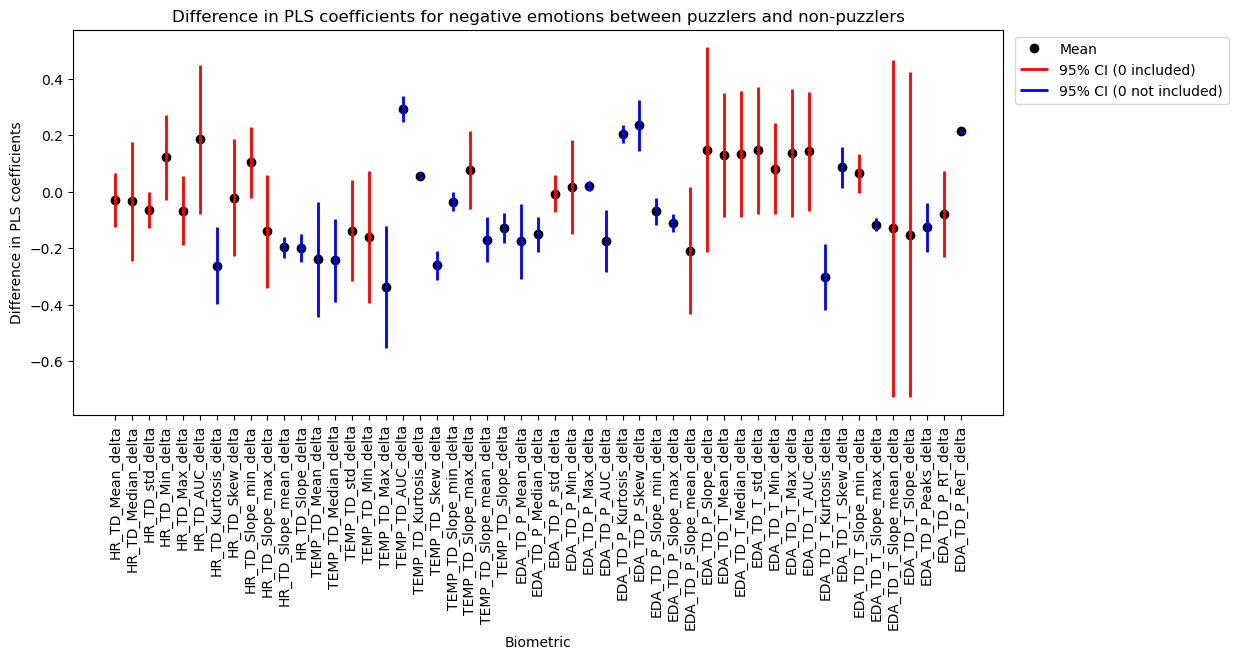

In [12]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
import numpy as np
from scipy.stats import t

# Define PLS object
pls = PLSRegression()

# parameters for cross-validation
n_comps = range(1, 12)
# Set up GridSearchCV
param_grid = {'n_components': n_comps}
grid = GridSearchCV(pls, param_grid, cv=10, n_jobs=-1, verbose=1, scoring=['neg_mean_squared_error', 'explained_variance'], refit='explained_variance')

# Fit the grid search model for negative emotions, puzzler 
search_puz_neg = grid.fit(X_puzzler, y_puzzler[['Neg_emotions']])
coef_puz_neg = grid.best_estimator_.coef_

# Fit the grid search model for negative emotions, non-puzzler 
search_nonpuz_neg = grid.fit(X_non_puzzler, y_non_puzzler[['Neg_emotions']])
coef_nonpuz_neg = grid.best_estimator_.coef_

# Difference between coefficients
coef_neg = coef_puz_neg - coef_nonpuz_neg

# Define jackknife resampling procedure
loo = LeaveOneOut()
n_samples = X_puzzler.shape[0]
puz_coefficients = []

# Refit the PLS model to each resampled dataset and obtain coefficients
for train_index, test_index in loo.split(X_puzzler):
    X_train, X_test = X_puzzler.iloc[train_index], X_puzzler.iloc[test_index]
    y_train, y_test = y_puzzler.iloc[train_index], y_puzzler.iloc[test_index]
    pls.fit(X_train, y_train[['Neg_emotions']])
    puz_coefficients.append(pls.coef_)

# Convert coefficients to array
puz_coefficients = np.array(puz_coefficients)


# Calculate bias and variance of coefficients
bias = (n_samples - 1) * (np.mean(puz_coefficients, axis=0) - coef_puz_neg)
variance = ((n_samples - 1) / n_samples) * np.sum((puz_coefficients - np.mean(puz_coefficients, axis=0)) ** 2, axis=0)

# Construct confidence intervals
alpha = 0.05  # significance level
t_critical = t.ppf(1 - alpha / 2, df=n_samples - 1)  # t critical value
margin_of_error = t_critical * np.sqrt(variance)
lower_bound_puz = coef_puz_neg - margin_of_error
upper_bound_puz = coef_puz_neg + margin_of_error

# Define jackknife resampling procedure
loo = LeaveOneOut()
n_samples = X_non_puzzler.shape[0]
nonpuz_coefficients = []

# Refit the PLS model to each resampled dataset and obtain coefficients
for train_index, test_index in loo.split(X_non_puzzler):
    X_train, X_test = X_non_puzzler.iloc[train_index], X_non_puzzler.iloc[test_index]
    y_train, y_test = y_non_puzzler.iloc[train_index], y_non_puzzler.iloc[test_index]
    pls.fit(X_train, y_train[['Neg_emotions']])
    nonpuz_coefficients.append(pls.coef_)

# Convert coefficients to array
nonpuz_coefficients = np.array(nonpuz_coefficients)


# Calculate bias and variance of coefficients
bias = (n_samples - 1) * (np.mean(nonpuz_coefficients, axis=0) - coef_nonpuz_neg)
variance = ((n_samples - 1) / n_samples) * np.sum((nonpuz_coefficients - np.mean(nonpuz_coefficients, axis=0)) ** 2, axis=0)


# Construct confidence intervals
alpha = 0.05  # significance level
t_critical = t.ppf(1 - alpha / 2, df=n_samples - 1)  # t critical value
margin_of_error = t_critical * np.sqrt(variance)
lower_bound_non = coef_nonpuz_neg - margin_of_error
upper_bound_non = coef_nonpuz_neg + margin_of_error

lower_bound = lower_bound_puz - lower_bound_non
upper_bound = upper_bound_puz - upper_bound_non

lower_bound_diff = lower_bound.mean(axis=1)
upper_bound_diff = upper_bound.mean(axis=1)


conf_int = np.concatenate((lower_bound_diff, upper_bound_diff), axis=0).reshape(2,51).T

# swap places of values in the array so that the first entry for each row is the smallest value
for i in range(51):
    if conf_int[i, 0] > conf_int[i, 1]:
        conf_int[i, 0], conf_int[i, 1] = conf_int[i, 1], conf_int[i, 0]

# Plot confidence intervals
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the mean as a point
ax.plot(coef_neg, 'ko', label='Mean')

# Plot vertical lines between lower and upper bounds
for i in range(len(coef_neg)):
    if conf_int[i,0] <= 0 <= conf_int[i,1]:
        ax.vlines(i, conf_int[i,0], conf_int[i,1], color='red', linestyle='-', linewidth=2, label='95% CI (0 included)')
    else:
        ax.vlines(i, conf_int[i,0], conf_int[i,1], color='blue', linestyle='-', linewidth=2, label='95% CI (0 not included)')

# Add labels and legend
ax.set_xlabel('Biometric')
ax.set_ylabel('Difference in PLS coefficients')
plt.xticks(range(0,51), X_puzzler.columns, rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.25, 1), loc='upper right')
plt.title('Difference in PLS coefficients for negative emotions between puzzlers and non-puzzlers')
# Show plot
plt.show()

In [11]:
coef_neg

array([[-0.03011952],
       [-0.03437202],
       [-0.06439309],
       [ 0.12132247],
       [-0.06685705],
       [ 0.18594792],
       [-0.2610238 ],
       [-0.0209266 ],
       [ 0.10480658],
       [-0.13935591],
       [-0.19713752],
       [-0.19797955],
       [-0.23964992],
       [-0.24299932],
       [-0.13843496],
       [-0.16078888],
       [-0.33654582],
       [ 0.29201863],
       [ 0.05669514],
       [-0.25991772],
       [-0.03500562],
       [ 0.07571538],
       [-0.16948234],
       [-0.12811954],
       [-0.17520718],
       [-0.15114813],
       [-0.00614959],
       [ 0.01752779],
       [ 0.02130463],
       [-0.17379022],
       [ 0.20516961],
       [ 0.23504289],
       [-0.06956261],
       [-0.11046686],
       [-0.20887451],
       [ 0.14907565],
       [ 0.12970942],
       [ 0.13407444],
       [ 0.14635631],
       [ 0.08140827],
       [ 0.13723731],
       [ 0.14312964],
       [-0.30221468],
       [ 0.08669027],
       [ 0.06496004],
       [-0

In [16]:
# we only wish to keep those columns where the value from coef_neg are among the 10 largest in abosulte value
# we will then use these columns for the PLS model
abs_coef_neg = np.abs(coef_neg)
abs_coef_neg = abs_coef_neg.flatten()
abs_coef_neg = np.sort(abs_coef_neg)
abs_coef_neg = abs_coef_neg[::-1]
abs_coef_neg = abs_coef_neg[:10]
abs_coef_neg = abs_coef_neg.tolist()

# find the columns that are among the 10 largest in absolute value
columns = []
for i in range(51):
    for j in range(10):
        if abs(coef_neg.flatten()[i]) == abs_coef_neg[j]:
            columns.append(i)

#### Columns for negative emotions to keep after Feature engeering

In [36]:
# We only wish to keep those columns where the confidence interval does not include 0. 
unsignificant_columns_negative = []
significant_columns_negative = []
sign_coef = []
for i in range(51):
    if conf_int[i,0] <= 0 <= conf_int[i,1]:
        unsignificant_columns_negative.append(X_puzzler.columns[i])
    else:
        significant_columns_negative.append(X_puzzler.columns[i])
        sign_coef.append(abs(coef_neg.flatten()[i]))


# Append abs_coef_neg to the columns, as dataframe 
df = pd.DataFrame(sign_coef, columns = ['coef'])
df['columns'] = significant_columns_negative
df = df.sort_values(by='coef', ascending=False)
sign_columns_negative = df.head(10)['columns'].tolist()


### Same exercise as before, but for positive emotions

Fitting 10 folds for each of 11 candidates, totalling 110 fits
Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, 

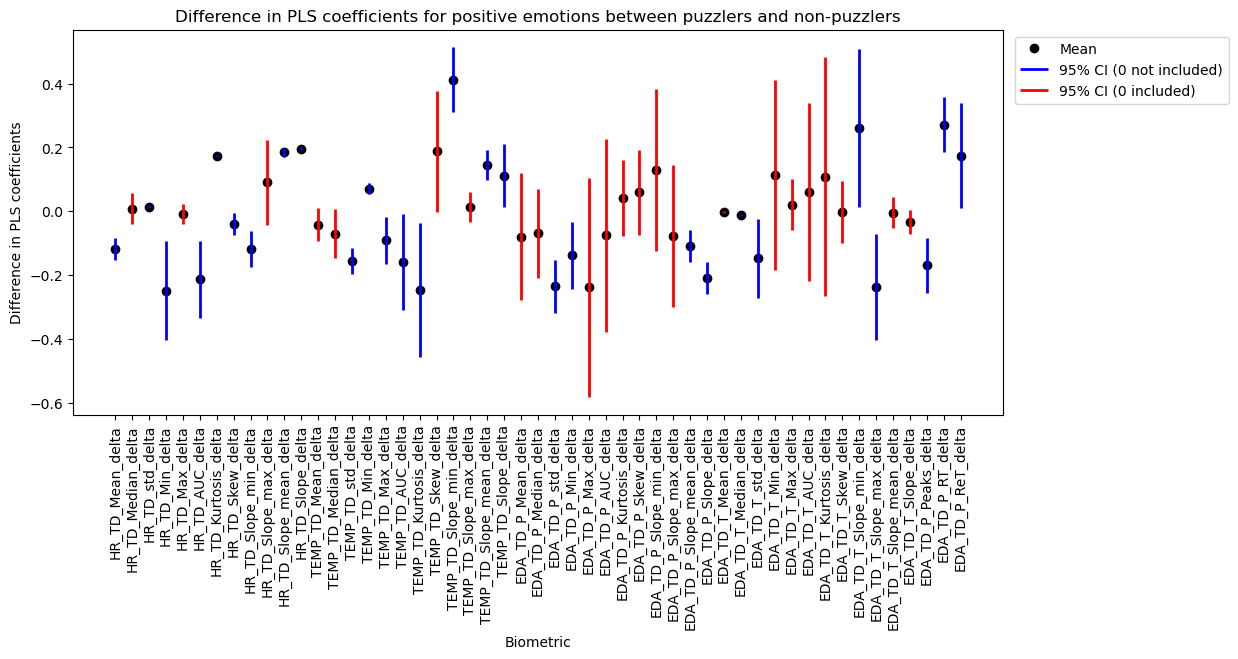

In [9]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
import numpy as np
from scipy.stats import t

# Define PLS object
pls = PLSRegression()

# parameters for cross-validation
n_comps = range(1, 12)
# Set up GridSearchCV
param_grid = {'n_components': n_comps}
grid = GridSearchCV(pls, param_grid, cv=10, n_jobs=-1, verbose=1, scoring=['neg_mean_squared_error', 'explained_variance'], refit='explained_variance')

# Fit the grid search model for negative emotions, puzzler 
search_puz_pos = grid.fit(X_puzzler, y_puzzler[['Pos_emotions']])
coef_puz_pos = grid.best_estimator_.coef_

# Fit the grid search model for negative emotions, non-puzzler 
search_nonpuz_pos = grid.fit(X_non_puzzler, y_non_puzzler[['Pos_emotions']])
coef_nonpuz_pos = grid.best_estimator_.coef_

# Difference between coefficients
coef_pos = coef_puz_pos - coef_nonpuz_pos

# Define jackknife resampling procedure
loo = LeaveOneOut()
n_samples = X_puzzler.shape[0]
puz_coefficients = []

# Refit the PLS model to each resampled dataset and obtain coefficients
for train_index, test_index in loo.split(X_puzzler):
    X_train, X_test = X_puzzler.iloc[train_index], X_puzzler.iloc[test_index]
    y_train, y_test = y_puzzler.iloc[train_index], y_puzzler.iloc[test_index]
    pls.fit(X_train, y_train[['Pos_emotions']])
    puz_coefficients.append(pls.coef_)

# Convert coefficients to array
puz_coefficients = np.array(puz_coefficients)


# Calculate bias and variance of coefficients
bias = (n_samples - 1) * (np.mean(puz_coefficients, axis=0) - coef_puz_pos)
variance = ((n_samples - 1) / n_samples) * np.sum((puz_coefficients - np.mean(puz_coefficients, axis=0)) ** 2, axis=0)

# Construct confidence intervals
alpha = 0.05  # significance level
t_critical = t.ppf(1 - alpha / 2, df=n_samples - 1)  # t critical value
margin_of_error = t_critical * np.sqrt(variance)
lower_bound_puz = coef_puz_pos - margin_of_error
upper_bound_puz = coef_puz_pos + margin_of_error

# Define jackknife resampling procedure
loo = LeaveOneOut()
n_samples = X_non_puzzler.shape[0]
nonpuz_coefficients = []

# Refit the PLS model to each resampled dataset and obtain coefficients
for train_index, test_index in loo.split(X_non_puzzler):
    X_train, X_test = X_non_puzzler.iloc[train_index], X_non_puzzler.iloc[test_index]
    y_train, y_test = y_non_puzzler.iloc[train_index], y_non_puzzler.iloc[test_index]
    pls.fit(X_train, y_train[['Pos_emotions']])
    nonpuz_coefficients.append(pls.coef_)

# Convert coefficients to array
nonpuz_coefficients = np.array(nonpuz_coefficients)


# Calculate bias and variance of coefficients
bias = (n_samples - 1) * (np.mean(nonpuz_coefficients, axis=0) - coef_nonpuz_pos)
variance = ((n_samples - 1) / n_samples) * np.sum((nonpuz_coefficients - np.mean(nonpuz_coefficients, axis=0)) ** 2, axis=0)


# Construct confidence intervals
alpha = 0.05  # significance level
t_critical = t.ppf(1 - alpha / 2, df=n_samples - 1)  # t critical value
margin_of_error = t_critical * np.sqrt(variance)
lower_bound_non = coef_nonpuz_pos - margin_of_error
upper_bound_non = coef_nonpuz_pos + margin_of_error

lower_bound = lower_bound_puz - lower_bound_non
upper_bound = upper_bound_puz - upper_bound_non

lower_bound_diff = lower_bound.mean(axis=1)
upper_bound_diff = upper_bound.mean(axis=1)

conf_int = np.concatenate((lower_bound_diff, upper_bound_diff), axis=0).reshape(2,51).T

# swap places of values in the array so that the first entry for each row is the smallest value
for i in range(51):
    if conf_int[i, 0] > conf_int[i, 1]:
        conf_int[i, 0], conf_int[i, 1] = conf_int[i, 1], conf_int[i, 0]

# Plot confidence intervals
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the mean as a point
ax.plot(coef_pos, 'ko', label='Mean')

# Plot vertical lines between lower and upper bounds
for i in range(len(coef_pos)):
    if conf_int[i,0] <= 0 <= conf_int[i,1]:
        ax.vlines(i, conf_int[i,0], conf_int[i,1], color='red', linestyle='-', linewidth=2, label='95% CI (0 included)')
    else:
        ax.vlines(i, conf_int[i,0], conf_int[i,1], color='blue', linestyle='-', linewidth=2, label='95% CI (0 not included)')

# Add labels and legend
ax.set_xlabel('Biometric')
ax.set_ylabel('Difference in PLS coefficients')
plt.xticks(range(0,51), X_puzzler.columns, rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.25, 1), loc='upper right')
plt.title('Difference in PLS coefficients for positive emotions between puzzlers and non-puzzlers')
# Show plot
plt.show()

In [35]:
# We only wish to keep those columns where the confidence interval does not include 0
unsignificant_columns_positive = []
significant_columns_positive = []
sign_coef = []
for i in range(51):
    if conf_int[i,0] <= 0 <= conf_int[i,1]:
        unsignificant_columns_positive.append(X_puzzler.columns[i])
    else:
        significant_columns_positive.append(X_puzzler.columns[i])
        sign_coef.append(abs(coef_neg.flatten()[i]))

# Append abs_coef_neg to the columns, as dataframe 
df = pd.DataFrame(sign_coef, columns = ['coef'])
df['columns'] = significant_columns_positive
df = df.sort_values(by='coef', ascending=False)
sign_columns_positive = df.head(10)['columns'].tolist()

## PLS

### PLS for positive emotions
Now that we have the subset of features of which we are confident that they are significant, we can use PLS to find the most important features. <br>

In [37]:
# Positive emotions
# Puzzlers 

# Define PLS object
pls = PLSRegression()

# Select relevant columns
X_puzzler = puzzler[sign_columns_positive]

#normalize data OBS: Måske ikke nødvendigt
X_puzzler = (X_puzzler - X_puzzler.mean()) / X_puzzler.std()

# parameters for cross-validation
n_comps = range(1, 12)
# Set up GridSearchCV
param_grid = {'n_components': n_comps}
grid = GridSearchCV(pls, param_grid, cv=10, n_jobs=-1, verbose=1, scoring=['neg_mean_squared_error', 'explained_variance'], refit='explained_variance')

# Fit the grid search model
search_puz_pos = grid.fit(X_puzzler, y_puzzler[['Pos_emotions']])
coef_puz_pos =grid.best_estimator_.coef_

# Non-puzzlers
# Define PLS object
pls = PLSRegression()

# Select relevant columns
X_non_puzzler = non_puzzler[sign_columns_positive]

#normalize data OBS: Måske ikke nødvendigt
X_non_puzzler = (X_non_puzzler - X_non_puzzler.mean()) / X_non_puzzler.std()

# parameters for cross-validation
n_comps = range(1, 12)
# Set up GridSearchCV
param_grid = {'n_components': n_comps}
grid = GridSearchCV(pls, param_grid, cv=10, n_jobs=-1, verbose=1, scoring=['neg_mean_squared_error', 'explained_variance'], refit='explained_variance')

# Fit the grid search model
search_non_pos = grid.fit(X_non_puzzler, y_non_puzzler[['Pos_emotions']])
coef_non_pos =grid.best_estimator_.coef_


Fitting 10 folds for each of 11 candidates, totalling 110 fits
Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py", line 660, in fit
    super().fit(X, Y)
  File "/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py", line 251, in fit
    raise ValueError(
ValueError: `n_co

### PLS for negative emotions

In [38]:
# Negative emotions
# Puzzlers 

# Define PLS object
pls = PLSRegression()

# Select relevant columns
X_puzzler = puzzler[sign_columns_negative]

#normalize data OBS: Måske ikke nødvendigt
X_puzzler = (X_puzzler - X_puzzler.mean()) / X_puzzler.std()

# parameters for cross-validation
n_comps = range(1, 12)
# Set up GridSearchCV
param_grid = {'n_components': n_comps}
grid = GridSearchCV(pls, param_grid, cv=10, n_jobs=-1, verbose=1, scoring=['neg_mean_squared_error', 'explained_variance'], refit='explained_variance')

# Fit the grid search model
search_puz_neg = grid.fit(X_puzzler, y_puzzler[['Neg_emotions']])
coef_puz_neg =grid.best_estimator_.coef_

# Non-puzzlers
# Define PLS object
pls = PLSRegression()

# Select relevant columns
X_non_puzzler = non_puzzler[sign_columns_negative]

#normalize data OBS: Måske ikke nødvendigt
X_non_puzzler = (X_non_puzzler - X_non_puzzler.mean()) / X_non_puzzler.std()

# parameters for cross-validation
n_comps = range(1, 12)
# Set up GridSearchCV
param_grid = {'n_components': n_comps}
grid = GridSearchCV(pls, param_grid, cv=10, n_jobs=-1, verbose=1, scoring=['neg_mean_squared_error', 'explained_variance'], refit='explained_variance')

# Fit the grid search model
search_non_neg = grid.fit(X_non_puzzler, y_non_puzzler[['Neg_emotions']])
coef_non_neg =grid.best_estimator_.coef_


Fitting 10 folds for each of 11 candidates, totalling 110 fits
Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py", line 660, in fit
    super().fit(X, Y)
  File "/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py", line 251, in fit
    raise ValueError(
ValueError: `n_co

### Plotting

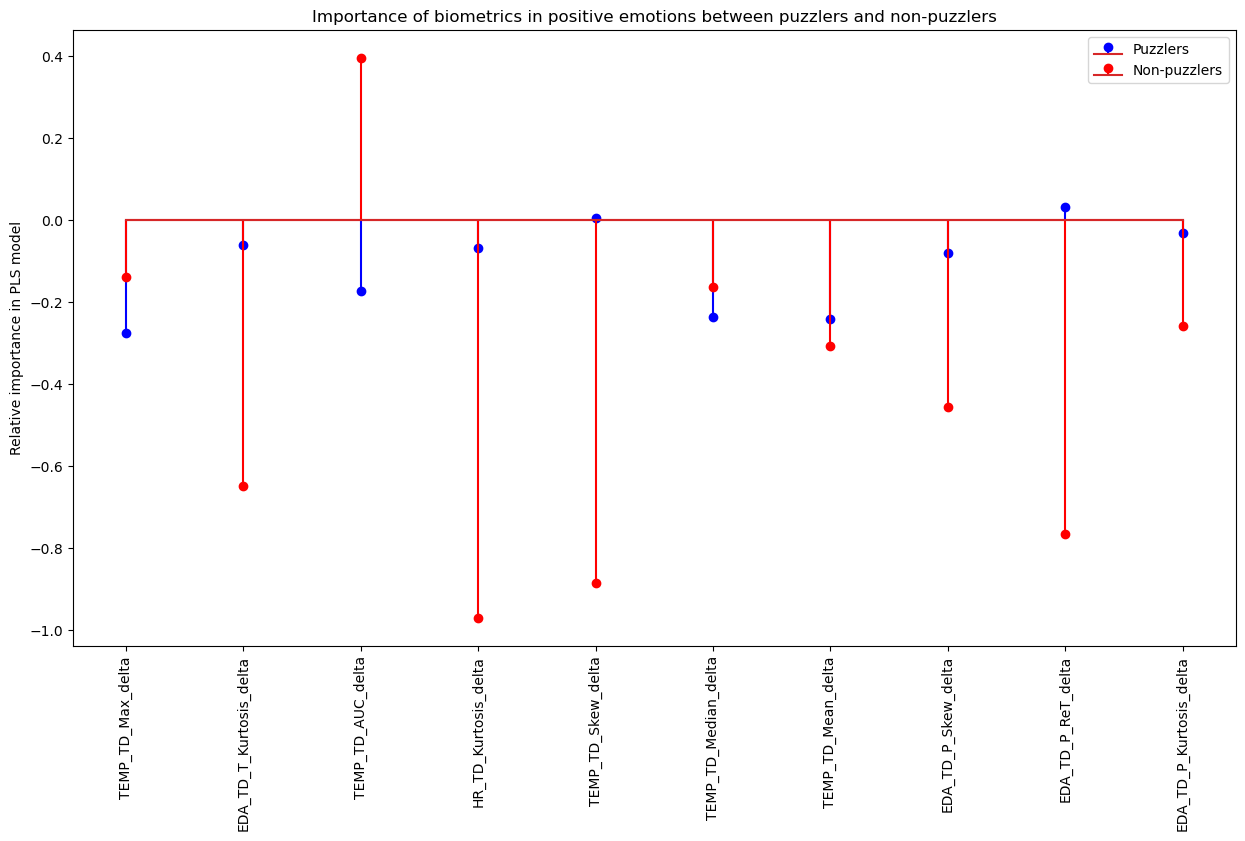

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot first pair
plt.ylabel('Relative importance in PLS model')
plt.stem(range(1,11), coef_puz_pos.squeeze(), linefmt='b-', markerfmt='bo')
plt.stem(range(1,11), coef_non_pos.squeeze(), linefmt='r-', markerfmt='ro')
plt.legend(['Puzzlers', 'Non-puzzlers'])
plt.xticks(range(1,11), sign_columns_positive, rotation=90)
plt.title("Importance of biometrics in positive emotions between puzzlers and non-puzzlers")
plt.show()

The plot above shows the most important features for positive emotions. <br>


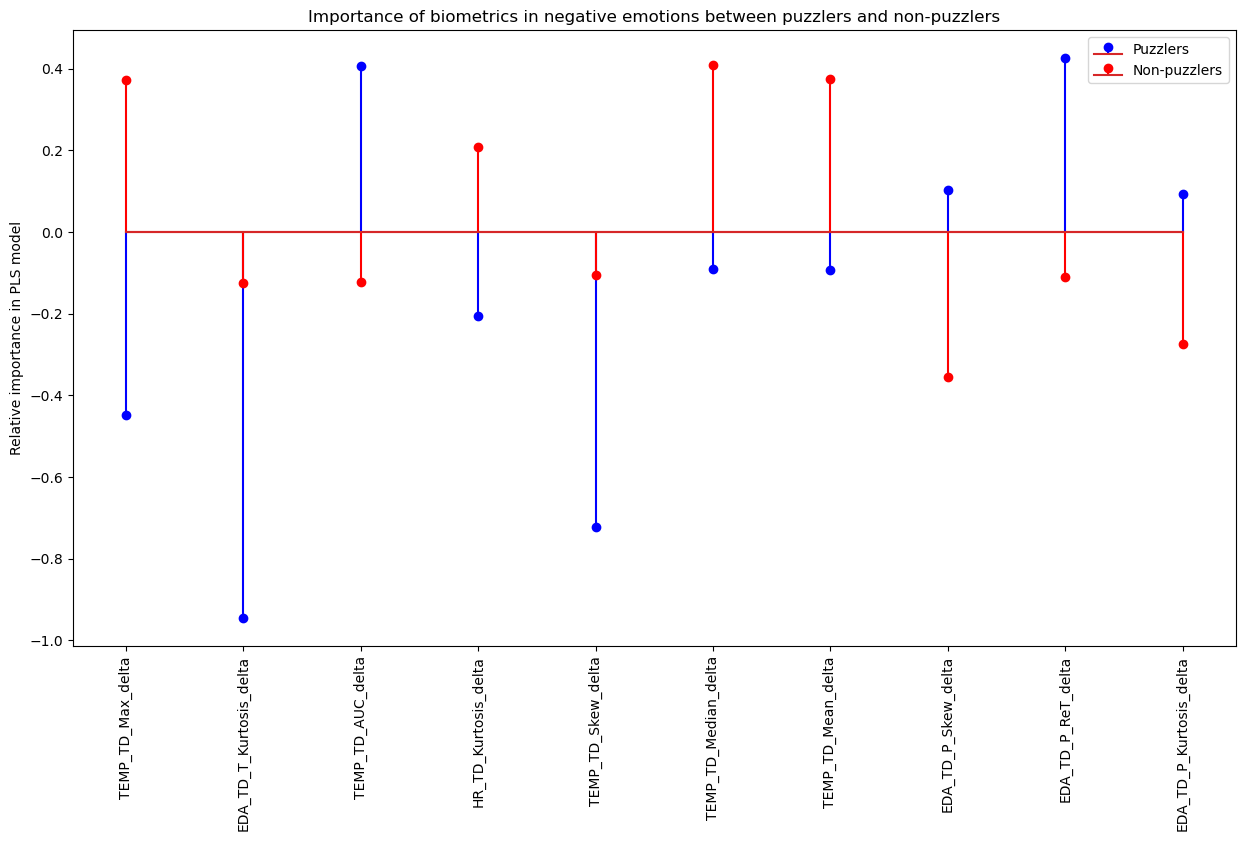

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot first pair
plt.ylabel('Relative importance in PLS model')
plt.stem(range(1,11), coef_puz_neg.squeeze(), linefmt='b-', markerfmt='bo')
plt.stem(range(1,11), coef_non_neg.squeeze(), linefmt='r-', markerfmt='ro')
plt.legend(['Puzzlers', 'Non-puzzlers'])
plt.xticks(range(1,11), sign_columns_negative, rotation=90)
plt.title("Importance of biometrics in negative emotions between puzzlers and non-puzzlers")
plt.show()

The plot above shows the most important features for negative emotions. <br>